In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

Our data is split between two .csv files, the main dataset containing transaction data, and a secondary dataset mapping each transaction group id to its localization (in Russian). For now, we shall ignore the localisation dataset, as it would require either manual processing, or some form of semantic embedding to be useful. At the moment, simple IDs shall suffice.

In [67]:
transactions = pd.read_csv("transactions_train.csv")
original_features = transactions.columns

Simply because my PC cannot handle the original amount of data, we'll be taking a small sample of our original data. Note that we're using the head() method instead of sample() since we want to take a subsample of clients, and not of transactions themselves. If we used sample(), we would be left with a large number of clients, each having only a handful of transactions, and that would not represent our original data.

In [68]:
transactions = transactions.head(1000000)

In [69]:
print(transactions.sample(10))

        client_id  trans_date  small_group  amount_rur
498904      35815         250           32     324.104
542879      35913         203            1       2.285
782303       5996         450           15       3.160
432424      34001          18            3      13.738
438586       7173         254            1       6.182
436233      27659         359            1       5.450
438321       8574         624            1      33.382
781525      35424         408            1      33.047
454286      46020         194           12      10.825
932285      41845         553            2      91.074


Checking for possible NAs. We're good.

In [70]:
print(transactions.isna().sum())

client_id      0
trans_date     0
small_group    0
amount_rur     0
dtype: int64


Downcasting our data, since processing even a small sample may require a lot of memory.

In [71]:
print('before downsampling:\n', transactions.dtypes)
transactions['client_id'] = pd.to_numeric(transactions['client_id'], downcast='unsigned')
transactions['trans_date'] = pd.to_numeric(transactions['trans_date'], downcast='unsigned')
transactions['small_group'] = pd.to_numeric(transactions['small_group'], downcast='signed')
transactions['amount_rur'] = pd.to_numeric(transactions['amount_rur'], downcast='float')

print('after downsampling:\n',transactions.dtypes)


before downsampling:
 client_id        int64
trans_date       int64
small_group      int64
amount_rur     float64
dtype: object
after downsampling:
 client_id       uint16
trans_date      uint16
small_group      int16
amount_rur     float32
dtype: object


Checking for potential corellations between features. It's better to limit the size of the analyzed sample even further, since otherwise it might take quite some time.

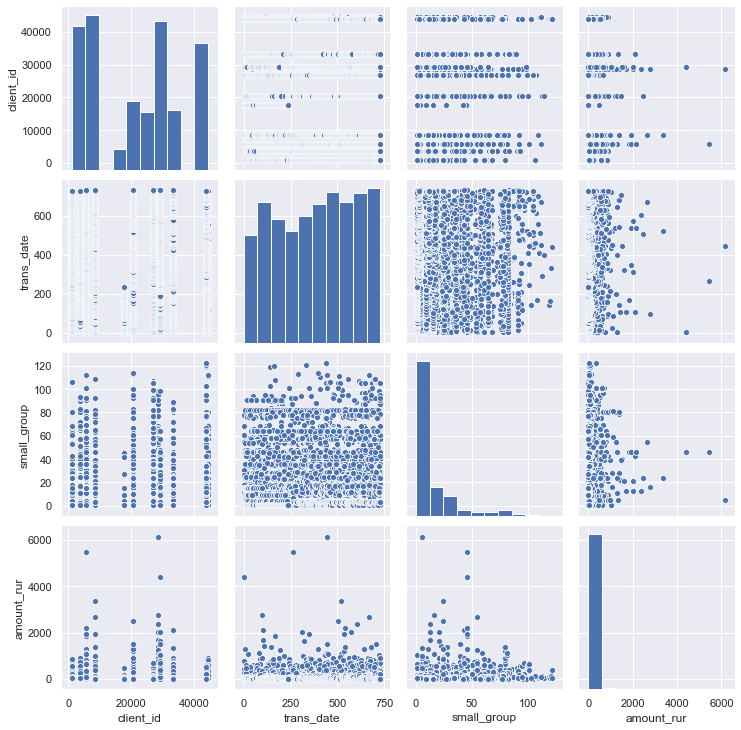

In [72]:
sample_size = 100000

sns.pairplot(transactions[['client_id','trans_date','small_group', 'amount_rur']].head(sample_size))

It looks like there's no definite correlation between our features. Let's check this just to be sure.

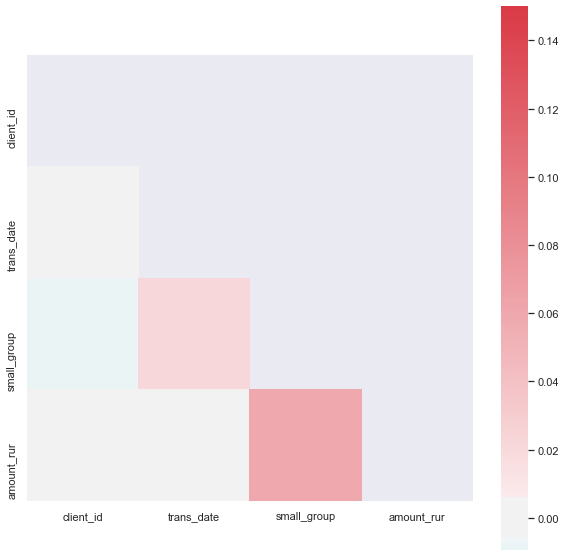

In [73]:
f, ax = plt.subplots(figsize=(10, 10))

corr = transactions[['client_id','trans_date','small_group', 'amount_rur']].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(200, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.15, center=0,
            square=True)

As we can see, the features seem to be mostly independent of each other, which is definitely a good thing.

# Engineering features

Let's start by deriving features from *amount_rur*. Here, there's not much room for deriving new features. The only thing that comes to mind is separating "large" transactions by introducing a categorical feature that is True only for transactions that exceed a ceratin threshold. This feature only makes sense for linear models (where it will introduce a certain bias for transactions exceeding the threshold); if we were using trees, this feature would simply be redundant.
There are a few ways to implement the threshold. We could take a set constant in the specified currency (say, separate transactions over 1000 roubles from the rest) or set it to a certain quantile of all transactions. In our dataset, a quantile of 99.6% corresponds to roughly 1000 roubles, so we  can start by using it.

In [75]:
quantile = .996

transactions['large_amount'] = False
transactions['large_amount'] = transactions['large_amount'].mask(transactions['amount_rur'] > transactions['amount_rur'].quantile(quantile), True)

print('Ratio of large amount transactions:', transactions[transactions['large_amount']].shape[0] / transactions.shape[0])

Ratio of large amount transactions: 0.004


Now, let's explore the *small_group* feature. As we can see below, this feature has quite a few unique values that are present for less than 0.01% of entries, some appearing as rare as once or twice in the dataset with millions of entries. 

In [76]:
counts = transactions['small_group'].value_counts(ascending=True)
print(counts)
print(counts[counts < transactions.shape[0] / 10000].count())

167         1
184         1
157         1
93          1
178         1
        ...  
4       52491
15      55531
3       84859
11     105067
1      323703
Name: small_group, Length: 184, dtype: int64
77


Let's group the values that together take up less than 1% of all entries into one.

In [77]:
frequencies = transactions['small_group'].value_counts(normalize=True, ascending=True)

threshold = frequencies[(frequencies.cumsum() > 0.01).idxmax()]
transactions['small_group_filtered'] = transactions['small_group'].mask(transactions['small_group'].map(transactions['small_group'].value_counts(normalize=True)) < threshold, -1)

counts = transactions['small_group_filtered'].value_counts(normalize=True, ascending=True)
print(counts)

68     0.000527
115    0.000554
125    0.000581
92     0.000614
112    0.000622
         ...   
4      0.052491
15     0.055531
3      0.084859
11     0.105067
1      0.323703
Name: small_group_filtered, Length: 80, dtype: float64


We could also mark values as "unpopular" based on their total transaction sum instead of their number of appearances.

In [78]:
normalized_sums = transactions.groupby('small_group').sum()['amount_rur']
normalized_sums /= normalized_sums.sum()
normalized_sorted_sums = normalized_sums.sort_values()

threshold = normalized_sorted_sums[(normalized_sorted_sums.cumsum() > 0.01).idxmax()]


transactions['small_group_filtered'] = transactions['small_group'].mask(transactions['small_group'].map(normalized_sums) < threshold, -1)

normalized_sums = transactions.groupby('small_group_filtered').sum()['amount_rur'].sort_values()
normalized_sums /= normalized_sums.sum()
print(normalized_sums)

small_group_filtered
47    0.000454
96    0.000457
49    0.000480
90    0.000542
87    0.000557
        ...   
2     0.035570
11    0.037520
5     0.043683
24    0.058255
1     0.245106
Name: amount_rur, Length: 92, dtype: float32


In [79]:
transactions['small_group'] = transactions['small_group_filtered']

transactions = transactions.drop(columns=['small_group_filtered'])

Now that we're working with a smaller set of values, let's see what features can be derived from it. First off, we can use an average of all transaction amounts within the same group to see how much any given transaction deviates from it. Since it's important for us to distinguish positive and negative deviation, we won't be using distance norms like L1 or L2 to get them, but instead a simple difference should suffice. Since subtraction is a linear combination, it will already be included in our linear model, so we can just add the average transaction amount of the necessary group to every transaction.

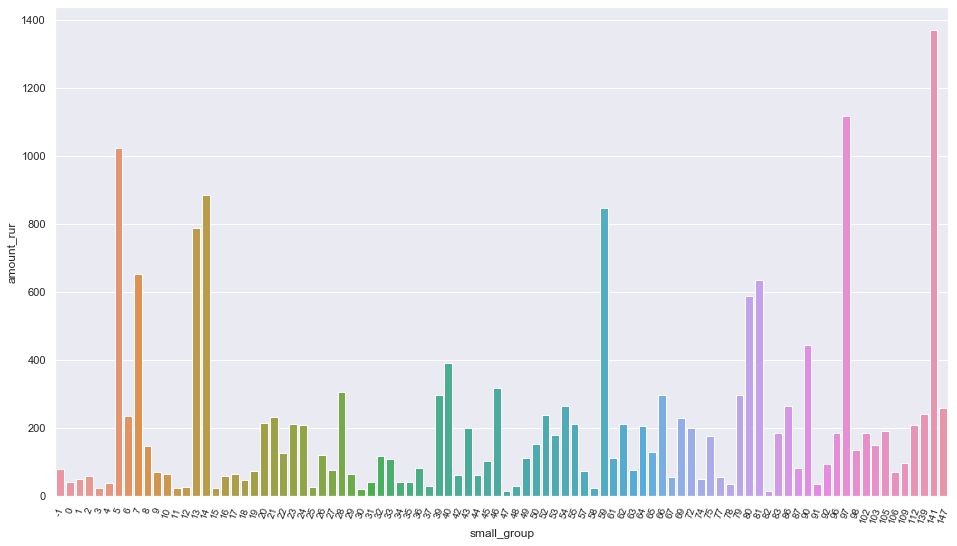

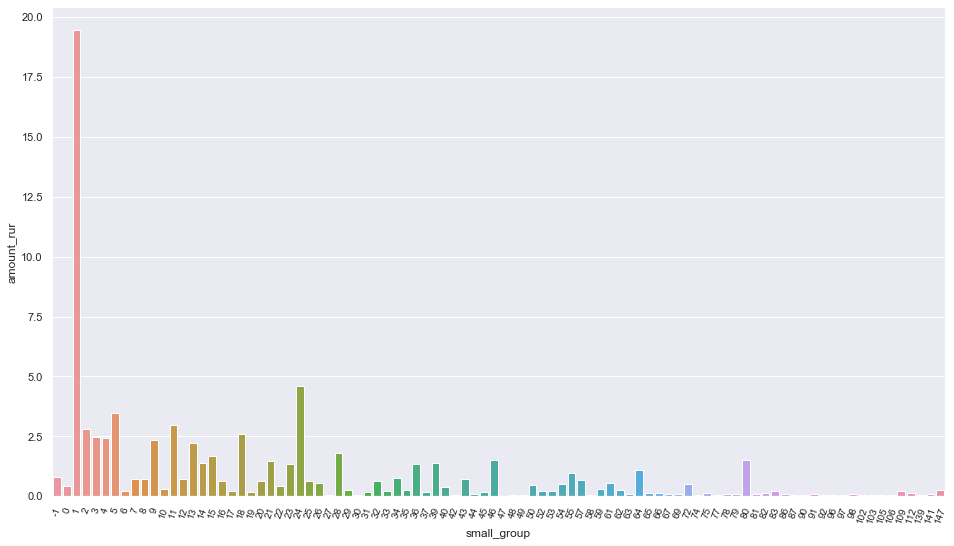

In [80]:
transactions['group_mean'] = transactions['small_group'].map(transactions.groupby('small_group').mean()['amount_rur'])


plt.figure(figsize = (16,9))
plot_data = transactions.groupby(['small_group']).mean()['amount_rur'].reset_index()
sns.barplot(x='small_group', y='amount_rur', data=plot_data)
plt.xticks(size=10, rotation=70)
plt.show()

plt.figure(figsize = (16,9))
plot_data = (transactions.groupby(['small_group']).sum()['amount_rur'] / (transactions['trans_date'].nunique() * transactions['client_id'].nunique())).reset_index()
sns.barplot(x='small_group', y='amount_rur', data=plot_data)
plt.xticks(size=10, rotation=70)
plt.show()

Now, let's derive some features from *trans_date*. This feature, when combined with others, gives us quite a lot of potential new features.

Here, we'll be assuming that day 0 is the beginning of the unix epoch. 

In [81]:
transactions['trans_date'] = pd.to_datetime(transactions['trans_date'], unit='d')

It might be useful for us to know what day of the week the transaction was made in, it could give us additional insight into spending habits of a given person.

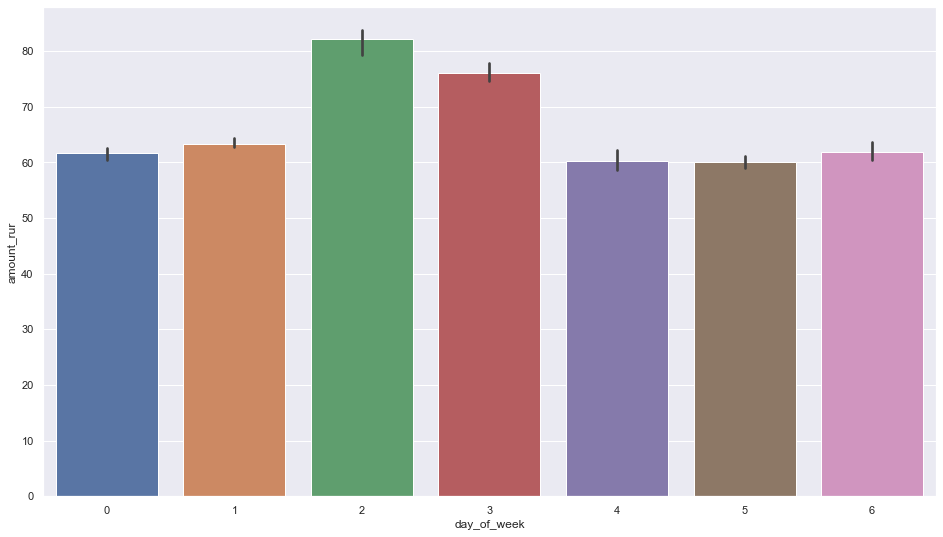

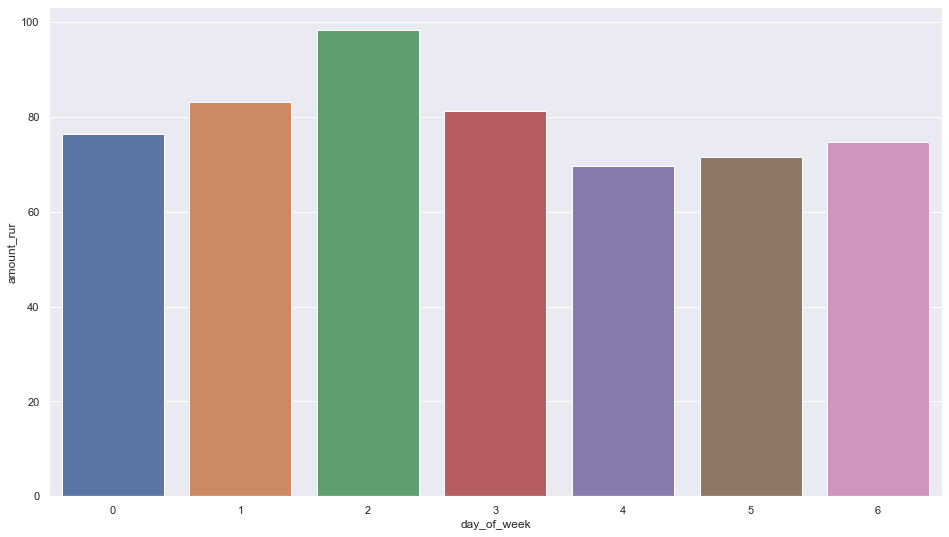

In [82]:
transactions['day_of_week'] = transactions['trans_date'].dt.dayofweek

day_of_week_counts = pd.Series(transactions['trans_date'].unique()).dt.dayofweek.value_counts()

plt.figure(figsize = (16,9))
sns.barplot(x='day_of_week', y='amount_rur', data=transactions, n_boot=10)
plt.show()


plot_data = transactions.groupby('day_of_week').sum()['amount_rur']
plot_data /= (day_of_week_counts * transactions['client_id'].nunique())
plt.figure(figsize = (16,9))
sns.barplot(x='day_of_week', y='amount_rur', data=plot_data.reset_index())
plt.show()

Based on this, we could add certain statistical data to every transactions, for example, various transaction averages.

In [83]:
baseline = transactions['day_of_week']
mapping = transactions.groupby('day_of_week').mean()['amount_rur']
transactions['general_day_of_week_transaction_average'] = baseline.map(mapping)
print(transactions[['day_of_week', 'general_day_of_week_transaction_average']])

baseline = pd.Series(list(zip(transactions['day_of_week'], transactions['small_group'])))
mapping = transactions.groupby(['day_of_week', 'small_group']).mean()['amount_rur']
transactions['general_day_of_week_transaction_group_average'] = baseline.map(mapping)
print(transactions['general_day_of_week_transaction_group_average'])

baseline = pd.Series(list(zip(transactions['client_id'], transactions['day_of_week'])))
mapping = transactions.groupby(['client_id','day_of_week']).mean()['amount_rur']
transactions['client_day_of_week_transaction_average'] = baseline.map(mapping)
print(transactions['client_day_of_week_transaction_average'])

baseline = pd.Series(list(zip(transactions['client_id'], transactions['day_of_week'], transactions['small_group'])))
mapping = transactions.groupby(['client_id','day_of_week', 'small_group']).mean()['amount_rur']
transactions['client_day_of_week_transaction_group_average'] = baseline.map(mapping)
print(transactions['client_day_of_week_transaction_group_average'])

        day_of_week  general_day_of_week_transaction_average
0                 2                                82.087128
1                 2                                82.087128
2                 4                                60.158249
3                 5                                60.043137
4                 6                                61.930832
...             ...                                      ...
999995            2                                82.087128
999996            2                                82.087128
999997            2                                82.087128
999998            2                                82.087128
999999            3                                76.016182

[1000000 rows x 2 columns]
0          39.633244
1          44.977692
2          20.382879
3          20.542004
4          21.049103
             ...    
999995     86.969536
999996     29.267790
999997    218.235580
999998     67.500946
999999    126.851418
Name: gen

As well as daily spending averages.

In [84]:
day_of_week_counts = pd.Series(transactions['trans_date'].unique()).dt.dayofweek.value_counts()
unique_clients = transactions['client_id'].nunique()

baseline = transactions['day_of_week']
mapping = transactions.groupby('day_of_week').sum()['amount_rur']
mapping /= (day_of_week_counts * unique_clients)
transactions['general_day_of_week_daily_average'] = baseline.map(mapping)
print(transactions['general_day_of_week_daily_average'])

baseline = pd.Series(list(zip(transactions['day_of_week'], transactions['small_group'])))
mapping = transactions.groupby(['day_of_week', 'small_group']).sum()['amount_rur']
mapping = mapping.reset_index()
mapping['amount_rur'] /= (mapping['day_of_week'].map(day_of_week_counts) * unique_clients)
mapping = mapping.set_index(['day_of_week', 'small_group'])
mapping = mapping['amount_rur']
transactions['general_day_of_week_daily_group_average'] = baseline.map(mapping)
print(transactions['general_day_of_week_daily_group_average'])

baseline = pd.Series(list(zip(transactions['client_id'], transactions['day_of_week'])))
mapping = transactions.groupby(['client_id', 'day_of_week']).sum()['amount_rur']
mapping = mapping.reset_index()
mapping['amount_rur'] /= (mapping['day_of_week'].map(day_of_week_counts))
mapping = mapping.set_index(['client_id', 'day_of_week'])
mapping = mapping['amount_rur']
transactions['client_day_of_week_daily_average'] = baseline.map(mapping)
print(transactions['client_day_of_week_daily_average'])

baseline = pd.Series(list(zip(transactions['client_id'], transactions['day_of_week'], transactions['small_group'])))
mapping = transactions.groupby(['client_id', 'day_of_week', 'small_group']).sum()['amount_rur']
mapping = mapping.reset_index()
mapping['amount_rur'] /= (mapping['day_of_week'].map(day_of_week_counts))
mapping = mapping.set_index(['client_id', 'day_of_week', 'small_group'])
mapping = mapping['amount_rur']
transactions['client_day_of_week_daily_group_average'] = baseline.map(mapping)
print(transactions['client_day_of_week_daily_group_average'])

0         98.246742
1         98.246742
2         69.705011
3         71.602998
4         74.788193
            ...    
999995    98.246742
999996    98.246742
999997    98.246742
999998    98.246742
999999    81.295105
Name: general_day_of_week_daily_average, Length: 1000000, dtype: float64
0          2.319483
1          0.273084
2          2.537158
3          2.761475
4          2.917496
            ...    
999995     1.678334
999996     1.968473
999997     6.353903
999998    26.323556
999999     0.774456
Name: general_day_of_week_daily_group_average, Length: 1000000, dtype: float64
0         81.166607
1         81.166607
2         49.593573
3         59.962463
4         57.812115
            ...    
999995    68.582806
999996    68.582806
999997    68.582806
999998    68.582806
999999    32.163553
Name: client_day_of_week_daily_average, Length: 1000000, dtype: float64
0          1.297635
1          0.697067
2          4.695533
3          6.211914
4          7.260279
            ... 

We could also repeat the same process for the day of month

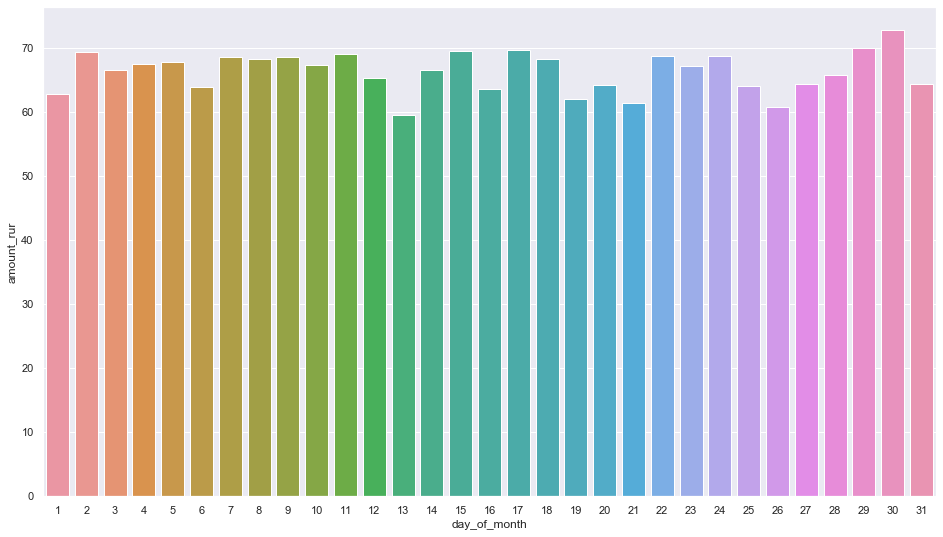

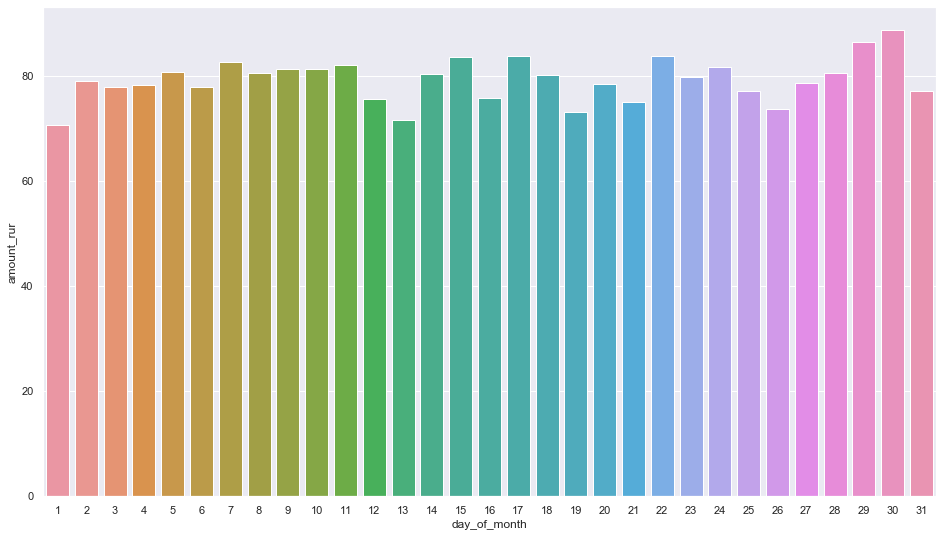

In [85]:
transactions['day_of_month'] = transactions['trans_date'].dt.day

day_of_month_counts = pd.Series(transactions['trans_date'].unique()).dt.day.value_counts()

plot_data = transactions.groupby('day_of_month').mean()['amount_rur'].reset_index()
plt.figure(figsize = (16,9))
sns.barplot(x='day_of_month', y='amount_rur', data=plot_data)
plt.show()

plot_data = transactions.groupby('day_of_month').sum()['amount_rur']
plot_data /= (day_of_month_counts * transactions['client_id'].nunique())
plt.figure(figsize = (16,9))
sns.barplot(x='day_of_month', y='amount_rur', data=plot_data.reset_index())
plt.show()

In [86]:
baseline = transactions['day_of_month']
mapping = transactions.groupby('day_of_month').mean()['amount_rur']
transactions['general_day_of_month_transaction_average'] = baseline.map(mapping)
print(transactions[['day_of_month', 'general_day_of_month_transaction_average']])

baseline = pd.Series(list(zip(transactions['day_of_month'], transactions['small_group'])))
mapping = transactions.groupby(['day_of_month', 'small_group']).mean()['amount_rur']
transactions['general_day_of_month_transaction_group_average'] = baseline.map(mapping)
print(transactions['general_day_of_month_transaction_group_average'])

baseline = pd.Series(list(zip(transactions['client_id'], transactions['day_of_month'])))
mapping = transactions.groupby(['client_id','day_of_month']).mean()['amount_rur']
transactions['client_day_of_month_transaction_average'] = baseline.map(mapping)
print(transactions['client_day_of_month_transaction_average'])

baseline = pd.Series(list(zip(transactions['client_id'], transactions['day_of_month'], transactions['small_group'])))
mapping = transactions.groupby(['client_id','day_of_month', 'small_group']).mean()['amount_rur']
transactions['client_day_of_month_transaction_group_average'] = baseline.map(mapping)
print(transactions['client_day_of_month_transaction_group_average'])

        day_of_month  general_day_of_month_transaction_average
0                  7                                 68.456757
1                  7                                 68.456757
2                  9                                 68.572823
3                 10                                 67.307770
4                 11                                 68.942307
...              ...                                       ...
999995            27                                 64.246216
999996            27                                 64.246216
999997            27                                 64.246216
999998            27                                 64.246216
999999            28                                 65.709930

[1000000 rows x 2 columns]
0          38.186573
1          38.913017
2          24.500399
3          23.522566
4          22.777651
             ...    
999995     84.840660
999996     24.237320
999997    258.308380
999998     49.698872
999999

In [87]:
day_of_month_counts = pd.Series(transactions['trans_date'].unique()).dt.day.value_counts()
unique_clients = transactions['client_id'].nunique()

baseline = transactions['day_of_month']
mapping = transactions.groupby('day_of_month').sum()['amount_rur']
mapping /= (day_of_month_counts * unique_clients)
transactions['general_day_of_month_daily_average'] = baseline.map(mapping)
print(transactions['general_day_of_month_daily_average'])

baseline = pd.Series(list(zip(transactions['day_of_month'], transactions['small_group'])))
mapping = transactions.groupby(['day_of_month', 'small_group']).sum()['amount_rur']
mapping = mapping.reset_index()
mapping['amount_rur'] /= (mapping['day_of_month'].map(day_of_month_counts) * unique_clients)
mapping = mapping.set_index(['day_of_month', 'small_group'])
mapping = mapping['amount_rur']
transactions['general_day_of_month_daily_group_average'] = baseline.map(mapping)
print(transactions['general_day_of_month_daily_group_average'])

baseline = pd.Series(list(zip(transactions['client_id'], transactions['day_of_month'])))
mapping = transactions.groupby(['client_id', 'day_of_month']).sum()['amount_rur']
mapping = mapping.reset_index()
mapping['amount_rur'] /= (mapping['day_of_month'].map(day_of_month_counts))
mapping = mapping.set_index(['client_id', 'day_of_month'])
mapping = mapping['amount_rur']
transactions['client_day_of_month_daily_average'] = baseline.map(mapping)
print(transactions['client_day_of_month_daily_average'])

baseline = pd.Series(list(zip(transactions['client_id'], transactions['day_of_month'], transactions['small_group'])))
mapping = transactions.groupby(['client_id', 'day_of_month', 'small_group']).sum()['amount_rur']
mapping = mapping.reset_index()
mapping['amount_rur'] /= (mapping['day_of_month'].map(day_of_month_counts))
mapping = mapping.set_index(['client_id', 'day_of_month', 'small_group'])
mapping = mapping['amount_rur']
transactions['client_day_of_month_daily_group_average'] = baseline.map(mapping)
print(transactions['client_day_of_month_daily_group_average'])

0         82.656305
1         82.656305
2         81.389047
3         81.340020
4         82.131159
            ...    
999995    78.767076
999996    78.767076
999997    78.767076
999998    78.767076
999999    80.638128
Name: general_day_of_month_daily_average, Length: 1000000, dtype: float64
0          2.435992
1          0.247809
2          3.090189
3          2.966000
4          2.774265
            ...    
999995     1.589990
999996     1.574367
999997     5.386125
999998    19.470817
999999     0.582763
Name: general_day_of_month_daily_group_average, Length: 1000000, dtype: float64
0         79.486961
1         79.486961
2         97.252708
3         46.853542
4         47.941544
            ...    
999995    45.614582
999996    45.614582
999997    45.614582
999998    45.614582
999999    76.349297
Name: client_day_of_month_daily_average, Length: 1000000, dtype: float32
0         3.334666
1         1.875708
2         7.725792
3         5.308458
4         6.679125
            ...   

And for the month of the transaction itself.

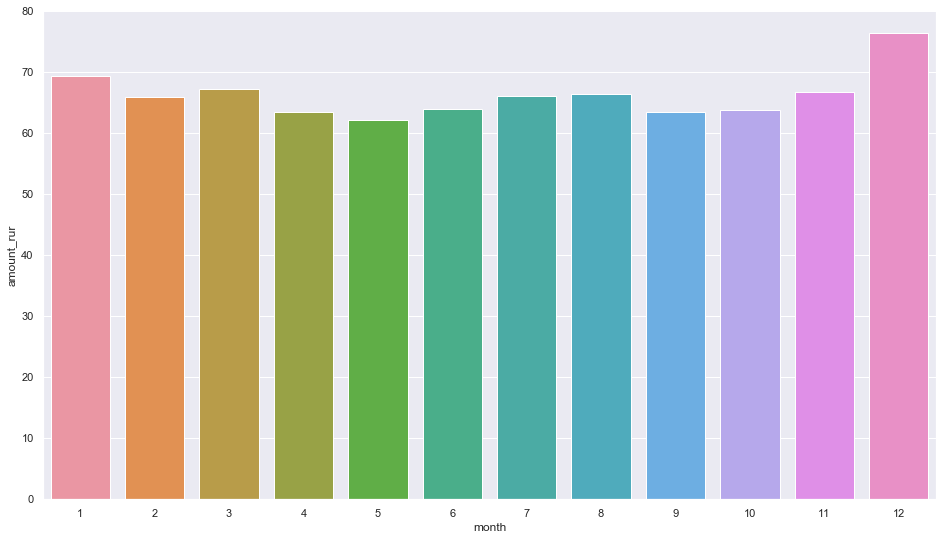

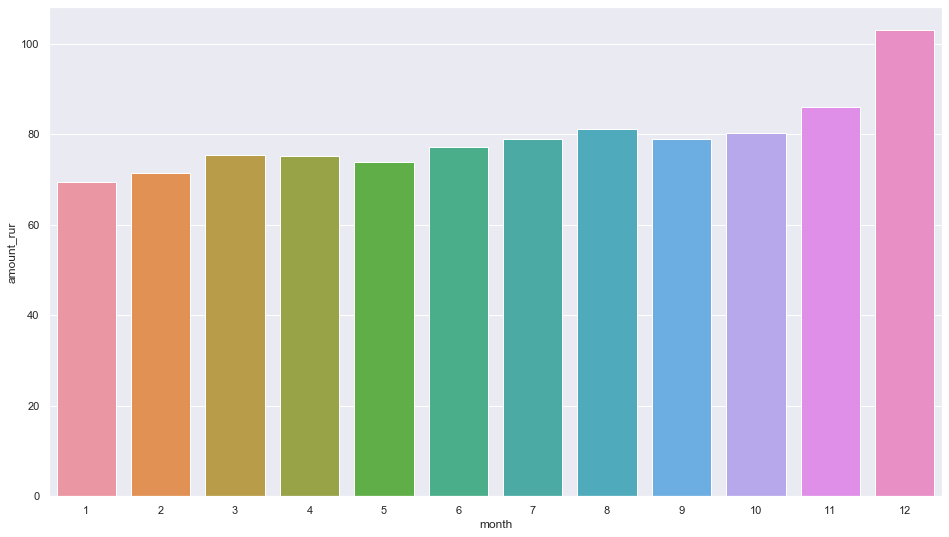

In [88]:
transactions['month'] = transactions['trans_date'].dt.month

month_counts = pd.Series(transactions['trans_date'].unique()).dt.month.value_counts()

plot_data = transactions.groupby('month').mean()['amount_rur'].reset_index()
plt.figure(figsize = (16,9))
sns.barplot(x='month', y='amount_rur', data=plot_data)
plt.show()

plot_data = transactions.groupby('month').sum()['amount_rur']
plot_data /= (month_counts * transactions['client_id'].nunique())
plt.figure(figsize = (16,9))
sns.barplot(x='month', y='amount_rur', data=plot_data.reset_index())
plt.show()

In [89]:
baseline = transactions['month']
mapping = transactions.groupby('month').mean()['amount_rur']
transactions['general_month_transaction_average'] = baseline.map(mapping)
print(transactions[['month', 'general_month_transaction_average']])

baseline = pd.Series(list(zip(transactions['month'], transactions['small_group'])))
mapping = transactions.groupby(['month', 'small_group']).mean()['amount_rur']
transactions['general_month_transaction_group_average'] = baseline.map(mapping)
print(transactions['general_month_transaction_group_average'])

baseline = pd.Series(list(zip(transactions['client_id'], transactions['month'])))
mapping = transactions.groupby(['client_id','month']).mean()['amount_rur']
transactions['client_month_transaction_average'] = baseline.map(mapping)
print(transactions['client_month_transaction_average'])

baseline = pd.Series(list(zip(transactions['client_id'], transactions['month'], transactions['small_group'])))
mapping = transactions.groupby(['client_id','month', 'small_group']).mean()['amount_rur']
transactions['client_month_transaction_group_average'] = baseline.map(mapping)
print(transactions['client_month_transaction_group_average'])

        month  general_month_transaction_average
0           1                          69.333054
1           1                          69.333054
2           1                          69.333054
3           1                          69.333054
4           1                          69.333054
...       ...                                ...
999995     10                          63.755856
999996     10                          63.755856
999997     10                          63.755856
999998     10                          63.755856
999999     10                          63.755856

[1000000 rows x 2 columns]
0          40.532215
1          41.792114
2          23.957071
3          23.957071
4          23.957071
             ...    
999995     77.546906
999996     24.035994
999997    220.585480
999998     45.780846
999999    122.382713
Name: general_month_transaction_group_average, Length: 1000000, dtype: float32
0         35.768669
1         35.768669
2         35.768669
3         35.7

In [90]:
month_counts = pd.Series(transactions['trans_date'].unique()).dt.month.value_counts()
unique_clients = transactions['client_id'].nunique()

baseline = transactions['month']
mapping = transactions.groupby('month').sum()['amount_rur']
mapping /= (month_counts * unique_clients)
transactions['general_month_daily_average'] = baseline.map(mapping)
print(transactions['general_month_daily_average'])

baseline = pd.Series(list(zip(transactions['month'], transactions['small_group'])))
mapping = transactions.groupby(['month', 'small_group']).sum()['amount_rur']
mapping = mapping.reset_index()
mapping['amount_rur'] /= (mapping['month'].map(month_counts) * unique_clients)
mapping = mapping.set_index(['month', 'small_group'])
mapping = mapping['amount_rur']
transactions['general_month_daily_group_average'] = baseline.map(mapping)
print(transactions['general_month_daily_group_average'])

baseline = pd.Series(list(zip(transactions['client_id'], transactions['month'])))
mapping = transactions.groupby(['client_id', 'month']).sum()['amount_rur']
mapping = mapping.reset_index()
mapping['amount_rur'] /= (mapping['month'].map(month_counts))
mapping = mapping.set_index(['client_id', 'month'])
mapping = mapping['amount_rur']
transactions['client_month_daily_average'] = baseline.map(mapping)
print(transactions['client_month_daily_average'])

baseline = pd.Series(list(zip(transactions['client_id'], transactions['month'], transactions['small_group'])))
mapping = transactions.groupby(['client_id', 'month', 'small_group']).sum()['amount_rur']
mapping = mapping.reset_index()
mapping['amount_rur'] /= (mapping['month'].map(month_counts))
mapping = mapping.set_index(['client_id', 'month', 'small_group'])
mapping = mapping['amount_rur']
transactions['client_month_daily_group_average'] = baseline.map(mapping)
print(transactions['client_month_daily_group_average'])

0         69.417045
1         69.417045
2         69.417045
3         69.417045
4         69.417045
            ...    
999995    80.269151
999996    80.269151
999997    80.269151
999998    80.269151
999999    80.269151
Name: general_month_daily_average, Length: 1000000, dtype: float64
0          2.278117
1          0.219587
2          2.107507
3          2.107507
4          2.107507
            ...    
999995     1.290082
999996     1.662442
999997     5.012035
999998    18.394885
999999     0.675786
Name: general_month_daily_group_average, Length: 1000000, dtype: float64
0         45.576210
1         45.576210
2         45.576210
3         45.576210
4         45.576210
            ...    
999995    37.272648
999996    37.272648
999997    37.272648
999998    37.272648
999999    37.272648
Name: client_month_daily_average, Length: 1000000, dtype: float32
0         1.697258
1         1.427242
2         7.445291
3         7.445291
4         7.445291
            ...   
999995    1.585984
9

Since our data is only from two years worth of transactions, there most likely isn't much to learn from the year the transaction was made in, so we won't be using it.

Now, let's engineer a few features that will generate certain statistics based on the data of transactions in a certain time interval before every transaction. These features are commonly used in fraud detection algorithms, but the patterns they detect may be useful for other related tasks. 

In [63]:
from tqdm.notebook import tqdm

time_intervals = ['1d', '2d', '7d', '14d', '30d', '365d']  # in days

to_plot = set() #client IDs

for time_interval in tqdm(time_intervals, desc='Time intervals processed:'):
    transactions['past_' + time_interval + '_interval_max'] = 0
    transactions['past_' + time_interval + '_interval_avg'] = 0
    transactions['past_' + time_interval + '_interval_sum'] = 0
    transactions['past_' + time_interval + '_interval_cnt'] = 0
    transactions['past_' + time_interval + '_interval_group_max'] = 0
    transactions['past_' + time_interval + '_interval_group_avg'] = 0
    transactions['past_' + time_interval + '_interval_group_sum'] = 0
    transactions['past_' + time_interval + '_interval_group_cnt'] = 0
    for client in tqdm(transactions['client_id'].unique(), desc='Clients processed:'):
        client_slice_idx = transactions[transactions['client_id'] == client].index
        client_slice = transactions.loc[client_slice_idx,:]
        transactions.loc[client_slice_idx, 'past_' + time_interval + '_interval_max'] = client_slice.set_index('trans_date')['amount_rur'].rolling(time_interval).max().reset_index()['amount_rur']
        transactions.loc[client_slice_idx, 'past_' + time_interval + '_interval_avg'] = client_slice.set_index('trans_date')['amount_rur'].rolling(time_interval).mean().reset_index()['amount_rur']
        transactions.loc[client_slice_idx, 'past_' + time_interval + '_interval_sum'] = client_slice.set_index('trans_date')['amount_rur'].rolling(time_interval).sum().reset_index()['amount_rur']
        transactions.loc[client_slice_idx, 'past_' + time_interval + '_interval_cnt'] = client_slice.set_index('trans_date')['amount_rur'].rolling(time_interval).count().reset_index()['amount_rur']
        if client in to_plot:
            plt.figure(figsize = (16,9))
            sns.lineplot(x='trans_date', y='past_' + time_interval + '_interval_max', data = transactions, ci=None)
            plt.show()
            plt.figure(figsize = (16,9))
            sns.lineplot(x='trans_date', y='past_' + time_interval + '_interval_avg', data = transactions, ci=None)
            plt.show()
            plt.figure(figsize = (16,9))
            sns.lineplot(x='trans_date', y='past_' + time_interval + '_interval_sum', data = transactions, ci=None)
            plt.show()
        for group in client_slice['small_group'].unique():
            group_slice_idx = transactions[((transactions['client_id'] == client) & (transactions['small_group'] == group))].index
            group_slice = transactions.loc[group_slice_idx,:]
            transactions.loc[group_slice_idx, 'past_' + time_interval + '_interval_group_max'] = np.array(group_slice.set_index('trans_date')['amount_rur'].rolling(time_interval).max().reset_index()['amount_rur'])
            transactions.loc[group_slice_idx, 'past_' + time_interval + '_interval_group_avg'] = np.array(group_slice.set_index('trans_date')['amount_rur'].rolling(time_interval).mean().reset_index()['amount_rur'])
            transactions.loc[group_slice_idx, 'past_' + time_interval + '_interval_group_sum'] = np.array(group_slice.set_index('trans_date')['amount_rur'].rolling(time_interval).sum().reset_index()['amount_rur'])
            transactions.loc[group_slice_idx, 'past_' + time_interval + '_interval_group_cnt'] = np.array(group_slice.set_index('trans_date')['amount_rur'].rolling(time_interval).count().reset_index()['amount_rur'])

KeyboardInterrupt: 